<a href="https://colab.research.google.com/github/LivioXie/ICSI435_Group/blob/main/GAN_proto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1, Generator Loss: 0.67997145652771, Discriminator Loss: 0.8574901819229126
Epoch 2, Generator Loss: 0.7006639838218689, Discriminator Loss: 0.7433503866195679
Epoch 3, Generator Loss: 0.7359551787376404, Discriminator Loss: 0.6835205554962158
Epoch 4, Generator Loss: 0.7800947427749634, Discriminator Loss: 0.6341959834098816
Epoch 5, Generator Loss: 0.8380340337753296, Discriminator Loss: 0.5829595327377319
Epoch 6, Generator Loss: 0.9073283672332764, Discriminator Loss: 0.5309277772903442
Epoch 7, Generator Loss: 0.9772768020629883, Discriminator Loss: 0.4847179353237152
Epoch 8, Generator Loss: 1.067838191986084, Discriminator Loss: 0.43217989802360535
Epoch 9, Generator Loss: 1.1690170764923096, Discriminator Loss: 0.3817484378814697
Epoch 10, Generator Loss: 1.2983465194702148, Discriminator Loss: 0.327347993850708
Epoch 11, Generator Loss: 1.4571559429168701, Discriminator Loss: 0.2729625105857849
Epoch 12, Generator Loss: 1.6277661323547363, Discriminator Loss: 0.225863546

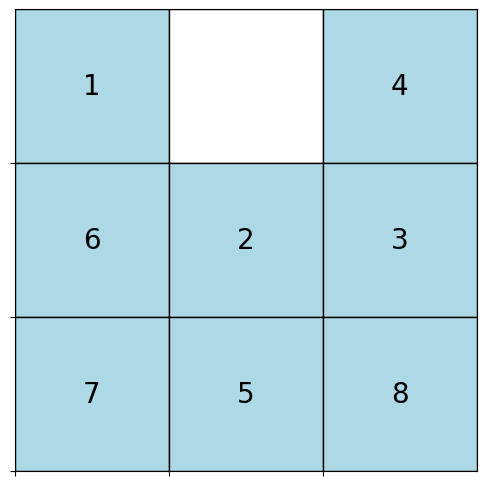

Epoch 101, Generator Loss: 8.02667236328125, Discriminator Loss: 0.00034158246126025915
Epoch 102, Generator Loss: 8.056270599365234, Discriminator Loss: 0.0003316431539133191
Epoch 103, Generator Loss: 8.084071159362793, Discriminator Loss: 0.00032255650148727
Epoch 104, Generator Loss: 8.115026473999023, Discriminator Loss: 0.0003127525560557842
Epoch 105, Generator Loss: 8.15159797668457, Discriminator Loss: 0.0003017973795067519
Epoch 106, Generator Loss: 8.177780151367188, Discriminator Loss: 0.000293905584840104
Epoch 107, Generator Loss: 8.21008014678955, Discriminator Loss: 0.0002846471907105297
Epoch 108, Generator Loss: 8.227123260498047, Discriminator Loss: 0.0002796739572659135
Epoch 109, Generator Loss: 8.252352714538574, Discriminator Loss: 0.00027274288004264235
Epoch 110, Generator Loss: 8.283509254455566, Discriminator Loss: 0.0002644182532094419
Epoch 111, Generator Loss: 8.314846992492676, Discriminator Loss: 0.0002563299785833806
Epoch 112, Generator Loss: 8.3460502

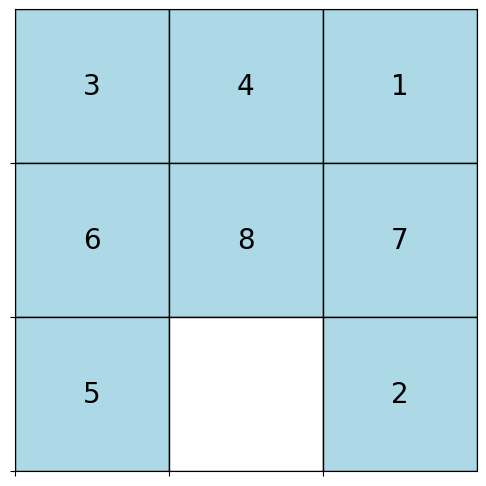

Epoch 201, Generator Loss: 10.450323104858398, Discriminator Loss: 3.0290264476207085e-05
Epoch 202, Generator Loss: 10.459495544433594, Discriminator Loss: 2.9986271329107694e-05
Epoch 203, Generator Loss: 10.474939346313477, Discriminator Loss: 2.9523160264943726e-05
Epoch 204, Generator Loss: 10.50132942199707, Discriminator Loss: 2.8761767680407502e-05
Epoch 205, Generator Loss: 10.521991729736328, Discriminator Loss: 2.817991298798006e-05
Epoch 206, Generator Loss: 10.543869018554688, Discriminator Loss: 2.7566327844397165e-05
Epoch 207, Generator Loss: 10.559255599975586, Discriminator Loss: 2.7136884455103427e-05
Epoch 208, Generator Loss: 10.57727336883545, Discriminator Loss: 2.6655356123228557e-05
Epoch 209, Generator Loss: 10.608968734741211, Discriminator Loss: 2.5833518520812504e-05
Epoch 210, Generator Loss: 10.632214546203613, Discriminator Loss: 2.5239492970285937e-05
Epoch 211, Generator Loss: 10.642822265625, Discriminator Loss: 2.4954377295216545e-05
Epoch 212, Gener

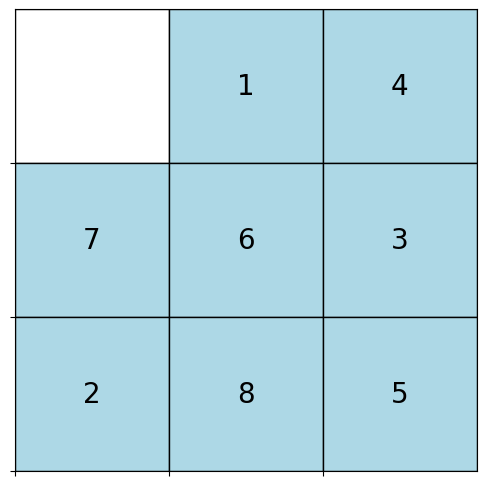

Epoch 301, Generator Loss: 12.419046401977539, Discriminator Loss: 4.215779426886002e-06
Epoch 302, Generator Loss: 12.434144020080566, Discriminator Loss: 4.152370820520446e-06
Epoch 303, Generator Loss: 12.456506729125977, Discriminator Loss: 4.061299023305764e-06
Epoch 304, Generator Loss: 12.466472625732422, Discriminator Loss: 4.019545940536773e-06
Epoch 305, Generator Loss: 12.485677719116211, Discriminator Loss: 3.943348019674886e-06
Epoch 306, Generator Loss: 12.514850616455078, Discriminator Loss: 3.833081336779287e-06
Epoch 307, Generator Loss: 12.537470817565918, Discriminator Loss: 3.7487084227905143e-06
Epoch 308, Generator Loss: 12.54511833190918, Discriminator Loss: 3.717612798936898e-06
Epoch 309, Generator Loss: 12.579225540161133, Discriminator Loss: 3.596488795665209e-06
Epoch 310, Generator Loss: 12.58449935913086, Discriminator Loss: 3.57454609911656e-06
Epoch 311, Generator Loss: 12.603282928466797, Discriminator Loss: 3.5083244256384205e-06
Epoch 312, Generator L

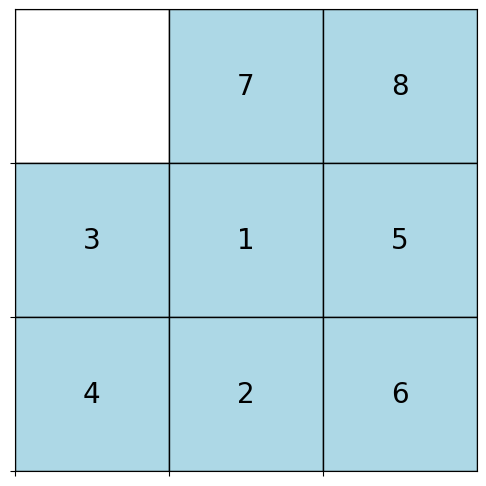

Epoch 401, Generator Loss: 14.272052764892578, Discriminator Loss: 6.680858177787741e-07
Epoch 402, Generator Loss: 14.295047760009766, Discriminator Loss: 6.535382794936595e-07
Epoch 403, Generator Loss: 14.32015609741211, Discriminator Loss: 6.375769885380578e-07
Epoch 404, Generator Loss: 14.333456039428711, Discriminator Loss: 6.290683245424589e-07
Epoch 405, Generator Loss: 14.347355842590332, Discriminator Loss: 6.203584348440927e-07
Epoch 406, Generator Loss: 14.376546859741211, Discriminator Loss: 6.030450663274678e-07
Epoch 407, Generator Loss: 14.388259887695312, Discriminator Loss: 5.958477800049877e-07
Epoch 408, Generator Loss: 14.40567684173584, Discriminator Loss: 5.857652922713896e-07
Epoch 409, Generator Loss: 14.421525955200195, Discriminator Loss: 5.765543846791843e-07
Epoch 410, Generator Loss: 14.43524169921875, Discriminator Loss: 5.686360395884549e-07
Epoch 411, Generator Loss: 14.45388412475586, Discriminator Loss: 5.585231974691851e-07
Epoch 412, Generator Loss

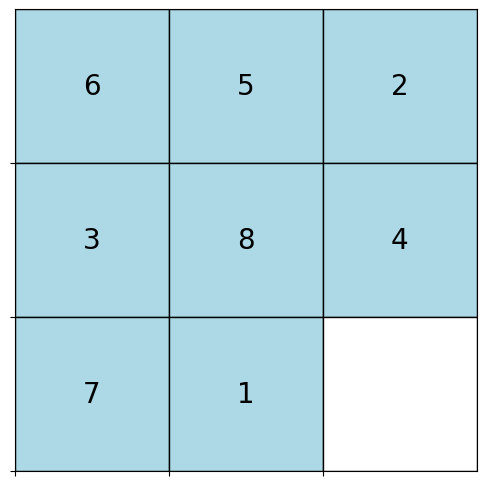

Epoch 501, Generator Loss: 16.037670135498047, Discriminator Loss: 1.1959190260313335e-07
Epoch 502, Generator Loss: 16.053050994873047, Discriminator Loss: 1.1780966957530836e-07
Epoch 503, Generator Loss: 16.068798065185547, Discriminator Loss: 1.1605240501921799e-07
Epoch 504, Generator Loss: 16.08747100830078, Discriminator Loss: 1.1403245991914446e-07
Epoch 505, Generator Loss: 16.107507705688477, Discriminator Loss: 1.1189313653403588e-07
Epoch 506, Generator Loss: 16.109567642211914, Discriminator Loss: 1.1159018242778984e-07
Epoch 507, Generator Loss: 16.13221549987793, Discriminator Loss: 1.0925694482466497e-07
Epoch 508, Generator Loss: 16.157291412353516, Discriminator Loss: 1.0672415129420187e-07
Epoch 509, Generator Loss: 16.16901206970215, Discriminator Loss: 1.0546825990331854e-07
Epoch 510, Generator Loss: 16.19061279296875, Discriminator Loss: 1.0337341649346854e-07
Epoch 511, Generator Loss: 16.217668533325195, Discriminator Loss: 1.0083869028676418e-07
Epoch 512, Gen

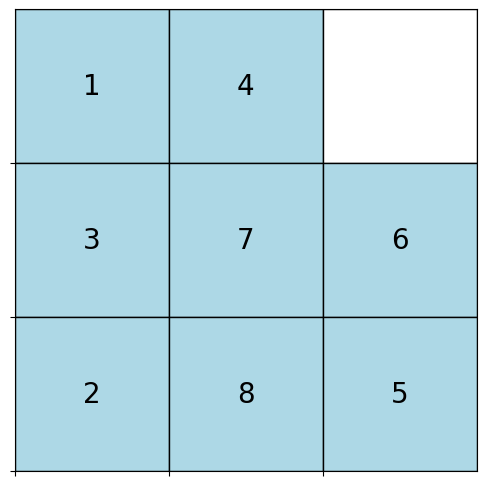

Epoch 601, Generator Loss: 17.6541690826416, Discriminator Loss: 2.8170443755470842e-08
Epoch 602, Generator Loss: 17.671558380126953, Discriminator Loss: 2.7752081521725813e-08
Epoch 603, Generator Loss: 17.689605712890625, Discriminator Loss: 2.744207172611368e-08
Epoch 604, Generator Loss: 17.704309463500977, Discriminator Loss: 2.6956655574394972e-08
Epoch 605, Generator Loss: 17.722450256347656, Discriminator Loss: 2.663870546371072e-08
Epoch 606, Generator Loss: 17.73522186279297, Discriminator Loss: 2.6412255493823977e-08
Epoch 607, Generator Loss: 17.753276824951172, Discriminator Loss: 2.59580801298398e-08
Epoch 608, Generator Loss: 17.761547088623047, Discriminator Loss: 2.5801240255418634e-08
Epoch 609, Generator Loss: 17.776033401489258, Discriminator Loss: 2.553095335144917e-08
Epoch 610, Generator Loss: 17.790555953979492, Discriminator Loss: 2.5123929603410033e-08
Epoch 611, Generator Loss: 17.807435989379883, Discriminator Loss: 2.47923601648381e-08
Epoch 612, Generator

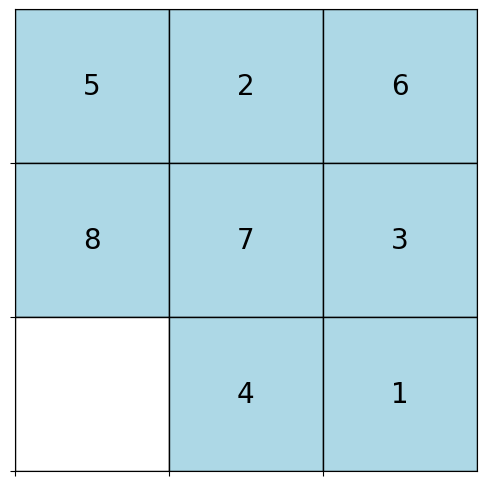

Epoch 701, Generator Loss: 19.115680694580078, Discriminator Loss: 1.0367983804826508e-08
Epoch 702, Generator Loss: 19.1281681060791, Discriminator Loss: 1.0160141172832482e-08
Epoch 703, Generator Loss: 19.14182472229004, Discriminator Loss: 1.0423669927206447e-08
Epoch 704, Generator Loss: 19.15591812133789, Discriminator Loss: 1.0146726125981331e-08
Epoch 705, Generator Loss: 19.181562423706055, Discriminator Loss: 1.0133978101123375e-08
Epoch 706, Generator Loss: 19.189207077026367, Discriminator Loss: 1.017533879377197e-08
Epoch 707, Generator Loss: 19.19882583618164, Discriminator Loss: 1.0173486941766896e-08
Epoch 708, Generator Loss: 19.216447830200195, Discriminator Loss: 1.0150898788197082e-08
Epoch 709, Generator Loss: 19.222867965698242, Discriminator Loss: 9.896502284334474e-09
Epoch 710, Generator Loss: 19.240493774414062, Discriminator Loss: 9.910780640609573e-09
Epoch 711, Generator Loss: 19.250843048095703, Discriminator Loss: 9.891991226140817e-09
Epoch 712, Generato

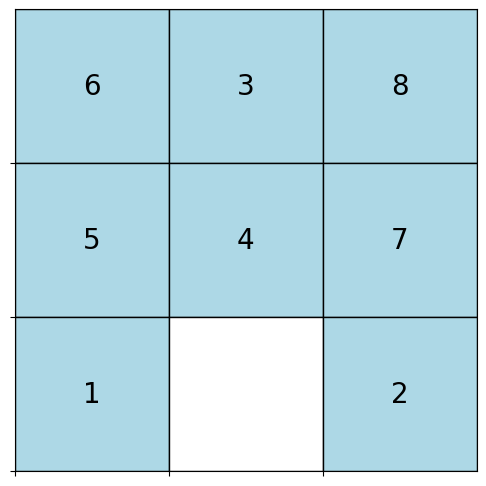

Epoch 801, Generator Loss: 20.35218048095703, Discriminator Loss: 6.484375703053047e-09
Epoch 802, Generator Loss: 20.36081886291504, Discriminator Loss: 6.628019022514309e-09
Epoch 803, Generator Loss: 20.369924545288086, Discriminator Loss: 6.392573581592842e-09
Epoch 804, Generator Loss: 20.374080657958984, Discriminator Loss: 6.539147445749904e-09
Epoch 805, Generator Loss: 20.378345489501953, Discriminator Loss: 6.689187870279056e-09
Epoch 806, Generator Loss: 20.40216827392578, Discriminator Loss: 6.383522155317678e-09
Epoch 807, Generator Loss: 20.408613204956055, Discriminator Loss: 6.524748741298936e-09
Epoch 808, Generator Loss: 20.41256332397461, Discriminator Loss: 6.304620825403617e-09
Epoch 809, Generator Loss: 20.425914764404297, Discriminator Loss: 6.433111821024795e-09
Epoch 810, Generator Loss: 20.447879791259766, Discriminator Loss: 6.5534822013546545e-09
Epoch 811, Generator Loss: 20.44211196899414, Discriminator Loss: 6.317464773530901e-09
Epoch 812, Generator Loss

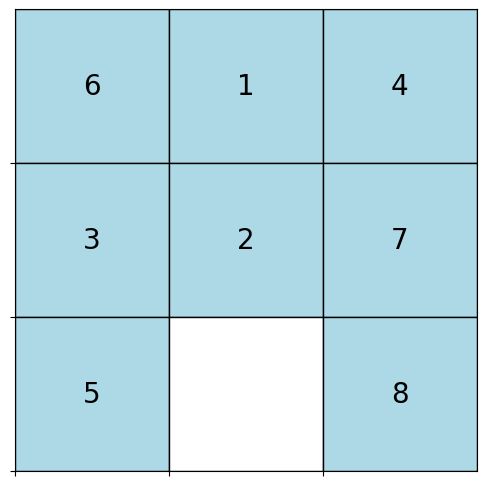

Epoch 901, Generator Loss: 21.24448585510254, Discriminator Loss: 5.664706481667281e-09
Epoch 902, Generator Loss: 21.254364013671875, Discriminator Loss: 5.7349565096842525e-09
Epoch 903, Generator Loss: 21.252166748046875, Discriminator Loss: 5.8129194790979e-09
Epoch 904, Generator Loss: 21.268943786621094, Discriminator Loss: 5.880796294377433e-09
Epoch 905, Generator Loss: 21.27171516418457, Discriminator Loss: 5.56039392307639e-09
Epoch 906, Generator Loss: 21.278955459594727, Discriminator Loss: 5.629242405547075e-09
Epoch 907, Generator Loss: 21.289722442626953, Discriminator Loss: 5.696527693999087e-09
Epoch 908, Generator Loss: 21.294635772705078, Discriminator Loss: 5.767871957829129e-09
Epoch 909, Generator Loss: 21.307621002197266, Discriminator Loss: 5.83590420433211e-09
Epoch 910, Generator Loss: 21.313724517822266, Discriminator Loss: 5.461460617084413e-09
Epoch 911, Generator Loss: 21.31832504272461, Discriminator Loss: 5.529673163806592e-09
Epoch 912, Generator Loss: 

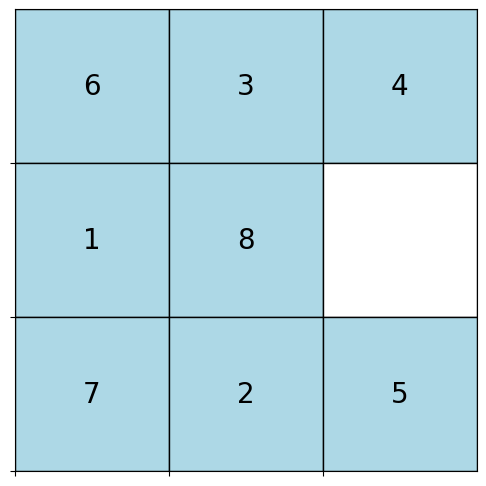

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, LeakyReLU, BatchNormalization
import matplotlib.pyplot as plt

# Constants
PUZZLE_SIZE = 3  # 3x3 puzzle
SEED_SIZE = 100
EPOCHS = 1000
BATCH_SIZE = 32

# Generate random 3x3 sliding puzzle configurations
def generate_puzzle_batch(batch_size):
    puzzles = []
    for _ in range(batch_size):
        puzzle = np.arange(PUZZLE_SIZE * PUZZLE_SIZE)
        np.random.shuffle(puzzle)
        puzzle = puzzle.reshape((PUZZLE_SIZE, PUZZLE_SIZE))
        puzzles.append(puzzle)
    return np.array(puzzles)

# Generator
def build_generator(seed_size):
    model = Sequential()
    model.add(Dense(128, input_dim=seed_size))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Dense(PUZZLE_SIZE * PUZZLE_SIZE, activation='softmax'))  # Output is a probability distribution
    model.add(Reshape((PUZZLE_SIZE, PUZZLE_SIZE)))
    return model

# Discriminator
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=(PUZZLE_SIZE, PUZZLE_SIZE)))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(1, activation='sigmoid'))
    return model

# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Build models
generator = build_generator(SEED_SIZE)
discriminator = build_discriminator()

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4, 0.5)

# Training step
@tf.function
def train_step(puzzles):
    noise = tf.random.normal([BATCH_SIZE, SEED_SIZE])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_puzzles = generator(noise, training=True)

        real_output = discriminator(puzzles, training=True)
        fake_output = discriminator(generated_puzzles, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        for puzzle_batch in dataset:
            gen_loss, disc_loss = train_step(puzzle_batch)

        # Print progress
        print(f"Epoch {epoch + 1}, Generator Loss: {gen_loss}, Discriminator Loss: {disc_loss}")

        # Generate and save a sample puzzle
        if (epoch + 1) % 100 == 0:
            sample_puzzle(generator)

# Function to sample a generated puzzle and plot
def sample_puzzle(generator_model):
    noise = tf.random.normal([1, SEED_SIZE])
    generated_puzzle = generator_model(noise, training=False).numpy().reshape((PUZZLE_SIZE, PUZZLE_SIZE))

    # Convert the generated puzzle to a valid permutation of numbers 0 to 8
    generated_puzzle = np.argsort(generated_puzzle.flatten())  # Ensure it's a valid permutation
    generated_puzzle = generated_puzzle.reshape((PUZZLE_SIZE, PUZZLE_SIZE))

    print("Generated Puzzle:")
    print(generated_puzzle)

    # Plot with labels
    fig, ax = plt.subplots(figsize=(6, 6))
    for i in range(PUZZLE_SIZE):
        for j in range(PUZZLE_SIZE):
            num = int(generated_puzzle[i, j])  # Convert to int to display as a number
            color = 'lightblue' if num != 0 else 'white'  # Set color for blank space (0)
            ax.add_patch(plt.Rectangle((j, PUZZLE_SIZE-i-1), 1, 1, facecolor=color, edgecolor='black'))

            if num != 0:  # Only add number to non-zero cells
                ax.text(j + 0.5, PUZZLE_SIZE-i-0.5, str(num), color='black', ha='center', va='center', fontsize=20)

    ax.set_xlim(0, PUZZLE_SIZE)
    ax.set_ylim(0, PUZZLE_SIZE)
    ax.set_xticks(np.arange(0, PUZZLE_SIZE, 1))
    ax.set_yticks(np.arange(0, PUZZLE_SIZE, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.show()

# Generate dataset and train
puzzle_data = generate_puzzle_batch(1000)
puzzle_dataset = tf.data.Dataset.from_tensor_slices(puzzle_data).batch(BATCH_SIZE)

train(puzzle_dataset, EPOCHS)
